In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error


from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
import gc
import seaborn as sns
import warnings

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from tsfresh.feature_extraction import feature_calculators
import copy

In [2]:
train = pd.read_csv("../input/train.csv", dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [3]:

# Display time_to_failure with more units of precision
pd.options.display.precision = 15

# Create a training file with simple derived features
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)

y_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    y_train.loc[segment, 'time_to_failure'] = y
    
    zc = np.fft.fft(x)
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X_tr.loc[segment, 'Rmean'] = realFFT.mean()
    X_tr.loc[segment, 'Rstd'] = realFFT.std()
    X_tr.loc[segment, 'Rmax'] = realFFT.max()
    X_tr.loc[segment, 'Rmin'] = realFFT.min()
    X_tr.loc[segment, 'Imean'] = imagFFT.mean()
    X_tr.loc[segment, 'Istd'] = imagFFT.std()
    X_tr.loc[segment, 'Imax'] = imagFFT.max()
    X_tr.loc[segment, 'Imin'] = imagFFT.min()
    
    
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'num_peaks_10'] = feature_calculators.number_peaks(x, 10)
    X_tr.loc[segment, 'autocorrelation_5'] = feature_calculators.autocorrelation(x, 5)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01) #Als je niet weet wat dit doet vraag het aan Pepijn
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'ave_roll_mean' + str(windows)] = x_roll_mean.mean()

In [4]:
means_dict = {}
for col in X_tr.columns:
    if X_tr[col].isnull().any():
        print(col)
        mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
        X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
        X_tr[col] = X_tr[col].fillna(mean_value)
        means_dict[col] = mean_value

scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

In [5]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(x)
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    
    X_test.loc[seg_id, 'Rmean'] = realFFT.mean()
    X_test.loc[seg_id, 'Rstd'] = realFFT.std()
    X_test.loc[seg_id, 'Rmax'] = realFFT.max()
    X_test.loc[seg_id, 'Rmin'] = realFFT.min()
    X_test.loc[seg_id, 'Imean'] = imagFFT.mean()
    X_test.loc[seg_id, 'Istd'] = imagFFT.std()
    X_test.loc[seg_id, 'Imax'] = imagFFT.max()
    X_test.loc[seg_id, 'Imin'] = imagFFT.min()
    
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()  

    X_test.loc[seg_id, 'kurt'] = x.kurtosis()

    X_test.loc[seg_id, 'num_peaks_10'] = feature_calculators.number_peaks(x, 10)
    X_test.loc[seg_id, 'autocorrelation_5'] = feature_calculators.autocorrelation(x, 5)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
                
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'ave_roll_mean' + str(windows)] = x_roll_mean.mean()
        
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])
        
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


In [6]:
n_fold = 8
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }


In [7]:
# from: https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_train, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Wed May 29 10:13:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1645]	training's l1: 1.52432	valid_1's l1: 2.14237
Fold 1 started at Wed May 29 10:13:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[935]	training's l1: 1.75341	valid_1's l1: 2.018
Fold 2 started at Wed May 29 10:13:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1152]	training's l1: 1.68167	valid_1's l1: 2.01658
Fold 3 started at Wed May 29 10:13:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1278]	training's l1: 1.62064	valid_1's l1: 2.17015
Fold 4 started at Wed May 29 10:13:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[820]	training's l1: 1.7919	valid_1's l1: 2.0199
Fold 5 started at Wed May 29 10:13:59 201

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


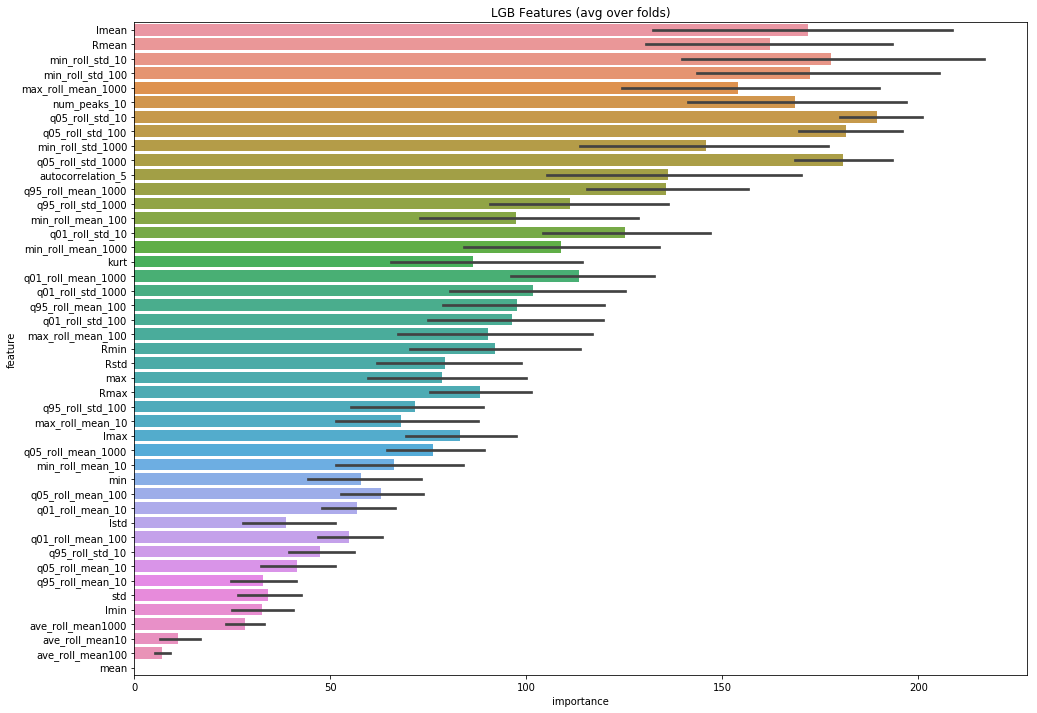

In [8]:
# alpha lambda accuracy instead https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89429#latest-517534 
# k-fold cross validation
# train with lightGBM (LB), experiment with objectives 
# From each time window, we compute a set of approximately 20 potentially relevant statistical features (e.g., mean, variance, kurtosis, and autocorrelation)
# https://static-content.springer.com/esm/art%3A10.1038%2Fs41561-018-0272-8/MediaObjects/41561_2018_272_MOESM1_ESM.pdf
# discussion on forum suggests that this metric and data is very volatile so create ensemble of methods such there is less variance (more robust)
# cv settings really important in this competition
# don't shuffle in your cv, introduces leakage
# some frequency domain techniques: https://www.kaggle.com/vettejeep/masters-final-project-model-lb-1-392 may need to use low/high pass filters to cut off noise
# so idea: blend (average) xgboost model, lstm, symbolic regressor (gplearn) predictions.
# use eli5 library to help explain model

oof_lgb, prediction_lgb, feature_importance = train_model(X=X_train_scaled, X_test=X_test_scaled, params=params, model_type='lgb', plot_feature_importance=True)

In [9]:
submission['time_to_failure'] = prediction_lgb
create_download_link(submission['time_to_failure'], filename = "LGBBoost_added_features.csv")

NameError: name 'create_download_link' is not defined

In [10]:
# This can be used to create a download link for the submission file

from IPython.display import HTML
import base64

def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)